# Modelos de Deep Learning

Laboratorio 03 – Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119 - Diego García 22404

Link del repositorio:<br>
https://github.com/EstebanZG999/Lab3_DS

### Imports

In [21]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
#TensorFlow no está instalado en este entorno.

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### Verifica entorno

In [22]:
# Verifica CUDA disponible
print("¿CUDA disponible?:", torch.cuda.is_available())

# Verifica GPU
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))

¿CUDA disponible?: True
GPU detectada: NVIDIA GeForce RTX 4060 Laptop GPU


### Preprocesamiento y Dataset

In [23]:
class PolyMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Dataset personalizado para PolyMNIST.
        - root_dir: carpeta raíz que contiene subcarpetas m0, m1, ..., m4.
        - transform: transformaciones a aplicar a cada imagen.
        """
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for label in range(5):  # m0 = 0, m1 = 1, ..., m4 = 4
            class_dir = os.path.join(root_dir, f"m{label}")
            for img_name in os.listdir(class_dir):
                if img_name.endswith(".png"):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("L")  # convertir a escala de grises
        if self.transform:
            image = self.transform(image)

        return image, label


Cargar el dataset y crear el DataLoader

In [24]:
# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((28, 28)),       # Asegura tamaño uniforme
    transforms.ToTensor(),             # Convierte a tensor (C, H, W)
    transforms.Normalize((0.5,), (0.5,))  # Normaliza a [-1, 1]
])

# Dataset y DataLoader
train_dir = "../data/PolyMNIST/MMNIST/train" 
test_dir = "../data/PolyMNIST/MMNIST/test"   

train_dataset = PolyMNISTDataset(root_dir=train_dir, transform=transform)
test_dataset = PolyMNISTDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verifica que funciona
images, labels = next(iter(train_loader))
print(f"Shape batch imágenes: {images.shape}")  # Esperado: (64, 1, 28, 28)
print(f"Labels: {labels[:10]}")


Shape batch imágenes: torch.Size([64, 1, 28, 28])
Labels: tensor([4, 4, 2, 0, 3, 4, 0, 0, 0, 4])


GPU Check en el loader

In [25]:
# GPU Check en el loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

# Mover un batch de prueba a GPU
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
print("Datos en GPU:", images.device)

Entrenando en: cuda
Datos en GPU: cuda:0


### Primer Modelo CNN 

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reducción de tamaño a la mitad
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Flatten final
        self.fc2 = nn.Linear(128, 5)  # 5 clases: m0 a m4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [1, 28, 28] -> [16, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [16, 14, 14] -> [32, 7, 7]
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

##### Entrenaiento primer modelo

In [27]:
# Función de pérdida y optimizador
model = CNNModel().to(device)
print("Modelo en:", next(model.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Verifica que estemos entrenando en GPU
assert device.type == "cuda", "La GPU no se está utilizando. Revisa tu configuración."

train_losses = []
train_accuracies = []

# Bucle de entrenamiento
epochs = 5
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Época {epoch}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Evaluación en el set de test
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= total
test_acc  = correct / total
print(f"\n— Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Modelo en: cuda:0
Época 1/5 — Loss: 0.2996, Accuracy: 0.8850
Época 2/5 — Loss: 0.0941, Accuracy: 0.9668
Época 3/5 — Loss: 0.0583, Accuracy: 0.9792
Época 4/5 — Loss: 0.0435, Accuracy: 0.9846
Época 5/5 — Loss: 0.0358, Accuracy: 0.9872

— Test Loss: 0.0321, Test Accuracy: 0.9888


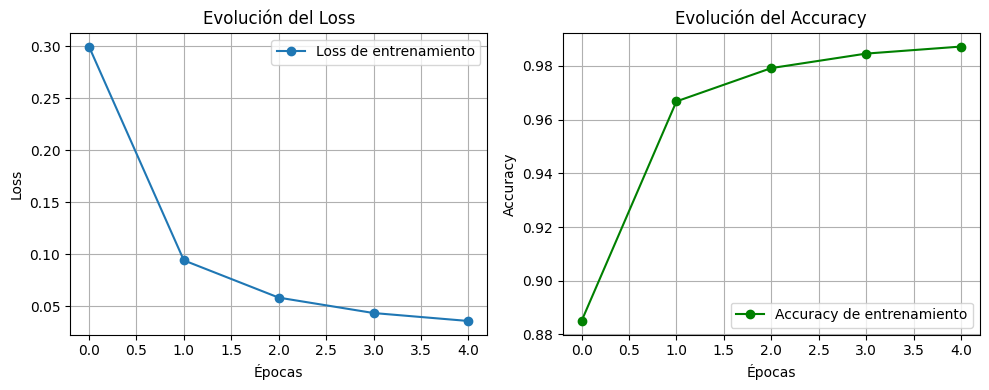

In [28]:
plt.figure(figsize=(10, 4))

# Gráfica del Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label="Loss de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución del Loss")
plt.grid(True)
plt.legend()

# Gráfica del Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green', label="Accuracy de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Modelo de Redes Neuronales

In [10]:
class PolyMNISTGenerator(Sequence):
    def __init__(self, file_list, batch_size=64, img_size=(28, 28), shuffle=True):
        self.file_list = file_list  # lista de (ruta_completa, nombre_archivo)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_list[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_files), *self.img_size, 1), dtype='float32')
        y = np.zeros((len(batch_files), 10), dtype='float32')

        for i, (full_path, fname) in enumerate(batch_files):
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype('float32') / 255.0
            X[i] = img.reshape(*self.img_size, 1)

            label = int(os.path.splitext(fname)[0].split('.')[1])
            y[i] = to_categorical(label, num_classes=10)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)


In [11]:
def collect_files(base_dir, modalities=["m0", "m1", "m2", "m3", "m4"]):
    file_list = []
    for mod in modalities:
        mod_path = os.path.join(base_dir, mod)
        for fname in os.listdir(mod_path):
            if fname.endswith('.png'):
                full_path = os.path.join(mod_path, fname)
                file_list.append((full_path, fname))
    return file_list

# Ruta base
BASE_DIR = "../data/PolyMNIST/MMNIST/train"

# Recolectar todos los archivos
all_files = collect_files(BASE_DIR)

# Dividir en train/val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Crear generadores
train_gen = PolyMNISTGenerator(train_files, batch_size=64)
val_gen = PolyMNISTGenerator(val_files, batch_size=64, shuffle=False)


In [12]:
RNModel = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])


In [18]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [19]:
RNModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = RNModel.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stop]
)


Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 237s 63ms/step - accuracy: 0.8271 - loss: 0.5541 - val_accuracy: 0.8031 - val_loss: 0.6472
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 126s 34ms/step - accuracy: 0.8310 - loss: 0.5431 - val_accuracy: 0.8135 - val_loss: 0.6312
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 126s 34ms/step - accuracy: 0.8340 - loss: 0.5336 - val_accuracy: 0.8150 - val_loss: 0.6205
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 127s 34ms/step - accuracy: 0.8371 - loss: 0.5231 - val_accuracy: 0.8018 - val_loss: 0.6436
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 126s 34ms/step - accuracy: 0.8360 - loss: 0.5256 - val_accuracy: 0.8213 - val_loss: 0.6121
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 125s 33ms/step - accuracy: 0.8386 - loss: 0.5148 - val_accuracy: 0.8183 - val_loss: 0.6154
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 33ms/step - accuracy: 0.8405 - loss: 0.5104 - val_accuracy: 0.8134 - val_loss: 0.6263
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 165s 44ms/step - accuracy: 

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8228 - loss: 0.6067
Precisión en validación: 82.15%


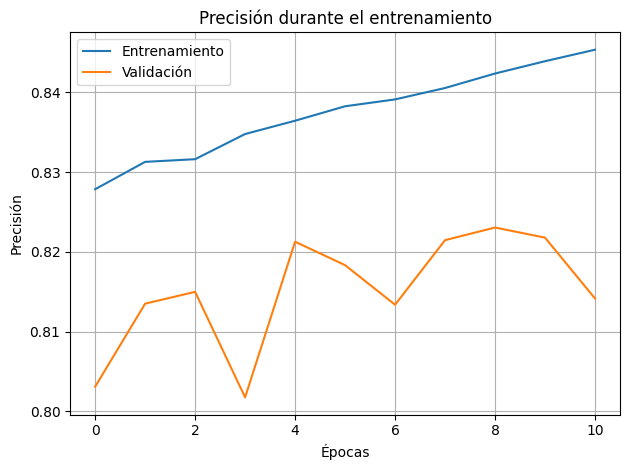

In [20]:
val_loss, val_acc = RNModel.evaluate(val_gen)
print(f"Precisión en validación: {val_acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
